In [41]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
from scipy import interpolate

9496
(13320, 42, 3)
13320

 Total final frames: 13314
Total final frames after removing acc outliers:  12308


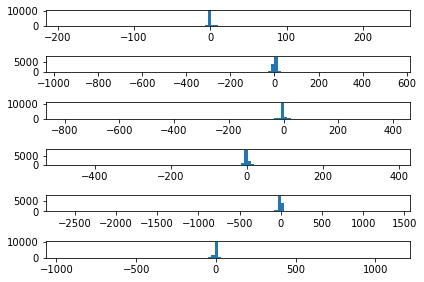

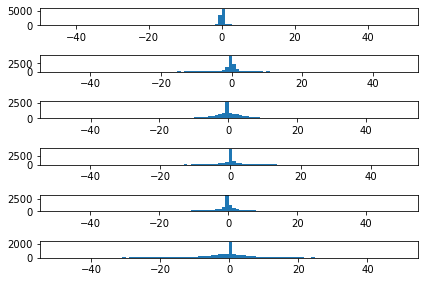

In [58]:
def return_angle(v1, v2):
    
    theta = 180*np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))/math.pi
    return theta

def resample_hand_keypoints(data, frames_list, multiplier, plot=False):
    
    new_frames_list = np.arange(frames_list[0], frames_list[-1], 1/multiplier)
    data_interpolated = np.zeros((np.shape(new_frames_list)[0], ))
    func = interpolate.interp1d(frames_list, data)
    data_interpolated = func(new_frames_list)

    if plot:

        p = 120
        plt.plot(new_frames_list[:p], data_interpolated[:p], 'r')
        plt.plot(frames_list[:p], data[:p], 'b')
        plt.legend(('upsampled', 'original'))
        plt.show()
        
    return data_interpolated, new_frames_list
    
###################################################
######## SECTION 3: LOAD FRAME INDEX PAIRS ########
###################################################

results_path = '/Users/sidoodler/projects/asl/datasets/video_asl/results'
session = 'Hanna_Session_7'

f = 1850
multiplier = 1
fps = 30
outlier_threshold = 50
diff = 3

final_input_folder = f'3d_keypoints_{f}'
full_interpolated_folder_path = f'{results_path}/{session}/3d_keypoints_{f}_interpolated'

if os.path.isdir(full_interpolated_folder_path) == False:
    os.mkdir(full_interpolated_folder_path)

frame_index_pairs_file = f'{results_path}/{session}/frame_index_pairs.txt'
file = open(frame_index_pairs_file, "r")
frame_index_pairs = file.read()
file.close()

frame_index_pairs = frame_index_pairs.split()
frames_list = np.array([int(frame_index_pairs[i]) for i in range(len(frame_index_pairs)) if i%2==1])

######################################
######## SECTION 4: MAIN CODE ########
######################################

count = 0
d = f"{results_path}/{session}/{final_input_folder}/"

for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print(count)

all_frames_keypoints = []

for i in range(count):

    file = open(f"{results_path}/{session}/{final_input_folder}/{i + 1}.txt", "r")
    kp_list = file.readlines()
    file.close()

    X = np.reshape(np.array([float(kp.split()[0]) for kp in kp_list]), (42,1))
    Y = np.reshape(np.array([float(kp.split()[1]) for kp in kp_list]), (42,1))
    Z = np.reshape(np.array([float(kp.split()[2].split('\n')[0]) for kp in kp_list]), (42,1))

    all_frames_keypoints.append(np.concatenate((X, Y, Z), axis=1))

all_frames_keypoints = np.array(all_frames_keypoints)

all_frames_keypoints_interpolated = np.zeros((math.floor((frames_list[-1] - frames_list[0])*multiplier),42,3))

for i in range(42):
    
    for j in range(3):
        
        new_data, new_frames_list = resample_hand_keypoints(np.reshape(all_frames_keypoints[:,i,j], (-1,)), frames_list, multiplier, False)
        
        all_frames_keypoints_interpolated[:,i,j] = new_data
        
print(np.shape(all_frames_keypoints_interpolated))

for i in range(len(new_frames_list)):
    
    file = open(f'{full_interpolated_folder_path}/{i+1}.txt', 'w')
    
    frame_keypoints = list(all_frames_keypoints_interpolated[i])
    
    string_array = np.reshape(np.array([str(k) for j in frame_keypoints for k in j]), (42,3))
    
    for j in string_array:
        
        file.writelines(' '.join(list(j)) + '\n')
        
    file.close()
    
file = open(f'{results_path}/{session}/frame_index_pairs_new.txt', 'w')

file.writelines(' '.join([str(int(i)) for i in new_frames_list]))

pos_prev, pos, pos_next = np.zeros((2,3)), np.zeros((2,3)), np.zeros((2,3))  # position/coordinates of the sensor wrt the camera coordinate system in 3 consecutive frames
positions = np.array([pos_prev, pos, pos_next])

virtual_imu_d = open(f"{results_path}/{session}/virtual_imu_d_new.txt", "w")
virtual_imu_n = open(f"{results_path}/{session}/virtual_imu_n_new.txt", "w")
final_frames = open(f"{results_path}/{session}/final_frames_new.txt", "w")

final_frames_list = []
x_accel1, y_accel1, z_accel1 = [], [], []
x_accel2, y_accel2, z_accel2 = [], [], []

count = 0
d = f"{full_interpolated_folder_path}"

for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print(count)

for i in range(1, count - (2*diff) + 1):
    
    imu_x_axis, imu_y_axis, imu_z_axis = np.zeros((2,3)), np.zeros((2,3)), np.zeros((2,3))  # the sensor axes wrt the camera coordinate system
    theta = np.zeros(2)  # angle at joint 6 on the 2 hands
    acc_wrt_cam, acc_wrt_sensor = np.zeros((2,3)), np.zeros((2,3))  # we want acc_wrt_sensor in the end
    hands_curr = np.zeros((2,21,3))  # all the 3d keypoints of the 2 hands in the current frame
    
    for j in range(3):
            
        file = open(f"{full_interpolated_folder_path}/{i+diff*j}.txt", "r")
        kp_list = file.readlines()
        file.close()

        X = np.reshape(-1*np.array([float(kp.split()[0]) for kp in kp_list]), (42,1))
        Y = np.reshape(np.array([float(kp.split()[1]) for kp in kp_list]), (42,1))
        Z = np.reshape(np.array([float(kp.split()[2].split('\n')[0]) for kp in kp_list]), (42,1))

        X1, Y1, Z1 = X[:21], Y[:21], Z[:21]
        X2, Y2, Z2 = X[21:], Y[21:], Z[21:]

        hands = np.array([np.concatenate((X1, Y1, Z1), axis=1), np.concatenate((X2, Y2, Z2), axis=1)])
        
        positions[j][0] = (hands[0][5] + hands[0][6])/2  # position of the imu sensor on hand1
        positions[j][1] = (hands[1][5] + hands[1][6])/2  # position of the imu sensor on hand2

        if j == 1:  # do this for the current frame only
            
            imu_y_axis[0] = (hands[0][6] - hands[0][5])/np.linalg.norm(hands[0][6] - hands[0][5])  # unit vector along bone 5-6 of hand1
            imu_y_axis[1] = (hands[1][6] - hands[1][5])/np.linalg.norm(hands[1][6] - hands[1][5])  # unit vector along bone 5-6 of hand2

            theta[0] = return_angle(hands[0][5] - hands[0][6], hands[0][7] - hands[0][6])  # angle at joint 5 of hand1
            theta[1] = return_angle(hands[1][5] - hands[1][6], hands[1][7] - hands[1][6])  # angle at joint 5 of hand2
            
            hands_curr = np.copy(hands)  # store current hands coordinates for later use. copy function is essential!
            
    e = 0  # threshold for angle at joint 6 in degrees
        
    if theta[0] <= 180 - e and theta[1] <= 180 - e:  # both hands need to have sufficient angle at joint 5
        
        time_diff = (new_frames_list[i-1+(2*diff)] - new_frames_list[i-1])/(fps*2)  # delta t = mean of the delta ts of (curr and prev) and (next and curr) frames. Instead of 30, put the fps of the videos.

        acc_wrt_cam = (positions[0] + positions[2] - 2*positions[1])/(time_diff**2)  

        imu_x_axis[0] = np.cross(hands_curr[0][5] - hands_curr[0][6], hands_curr[0][7] - hands_curr[0][6])  # cross product of vectors: 6->5 x 6->7
        imu_x_axis[0] = imu_x_axis[0]/np.linalg.norm(imu_x_axis[0])

        imu_x_axis[1] = np.cross(hands_curr[1][5] - hands_curr[1][6], hands_curr[1][7] - hands_curr[1][6])  # cross product of vectors: 6->5 x 6->7
        imu_x_axis[1] = imu_x_axis[1]/np.linalg.norm(imu_x_axis[1])

        imu_z_axis[0] = np.cross(imu_x_axis[0], imu_y_axis[0])  # simple cross product between x-axis and y-axis gives z-axis
        imu_z_axis[0] = imu_z_axis[0]/np.linalg.norm(imu_z_axis[0])

        imu_z_axis[1] = np.cross(imu_x_axis[1], imu_y_axis[1])  
        imu_z_axis[1] = imu_z_axis[1]/np.linalg.norm(imu_z_axis[1])

        R1 = np.zeros((3,3))  # for hand1
        R2 = np.zeros((3,3))  # for hand2

        A1 = np.array([imu_x_axis[0], imu_y_axis[0], imu_z_axis[0]])  # for hand1: matrix according to my algorithm as shared via google doc.

        # b1 is b vector in Ar = b, for finding all the rows r of R1
        for k, b1 in enumerate(np.array([[1,0,0], [0,1,0], [0,0,1]])):

            R1[k] = np.linalg.solve(A1,b1)  # gaussian elimination

        A2 = np.array([imu_x_axis[1], imu_y_axis[1], imu_z_axis[1]])  # for hand2

        for k, b2 in enumerate(np.array([[1,0,0], [0,1,0], [0,0,1]])):

            R2[k] = np.linalg.solve(A2,b2)

        acc_wrt_sensor = np.transpose(np.concatenate((np.matmul(R1, np.reshape(acc_wrt_cam[0], (3,1))),
                                                      np.matmul(R2, np.reshape(acc_wrt_cam[1], (3,1)))), axis=1))

        x_accel1.append(acc_wrt_sensor[0,0])
        y_accel1.append(acc_wrt_sensor[0,1])
        z_accel1.append(acc_wrt_sensor[0,2])

        x_accel2.append(acc_wrt_sensor[1,0])
        y_accel2.append(acc_wrt_sensor[1,1])
        z_accel2.append(acc_wrt_sensor[1,2])

        l = [str(acc_wrt_sensor[0,j]) for j in range(3)]
        virtual_imu_d.writelines(' '.join(l) + '\n')

        l = [str(acc_wrt_sensor[1,j]) for j in range(3)]
        virtual_imu_n.writelines(' '.join(l) + '\n')

        final_frames_list.append(str(int(new_frames_list[i+diff-1])))

#             if i < 201:
#                 draw_hands(np.concatenate((hands_curr[0][:,0], hands_curr[1][:,0]), axis=0), np.concatenate((hands_curr[0][:,1], hands_curr[1][:,1]), axis=0),
#                        np.concatenate((hands_curr[0][:,2], hands_curr[1][:,2]), axis=0), positions, imu_x_axis, imu_y_axis, imu_z_axis, i)

virtual_imu_d.close()
virtual_imu_n.close()

final_frames.writelines(' '.join(final_frames_list))
final_frames.close()

print("\n Total final frames:", len(final_frames_list))

fig, axes = plt.subplots(6, 1)

axes[0].hist(x_accel1, 100)
axes[1].hist(y_accel1, 100)
axes[2].hist(z_accel1, 100)

axes[3].hist(x_accel2, 100)
axes[4].hist(y_accel2, 100)
axes[5].hist(z_accel2, 100)

fig.tight_layout()

virtual_imu_d = open(f'{results_path}/{session}/virtual_imu_d_new.txt', 'r')
virtual_imu_n = open(f'{results_path}/{session}/virtual_imu_n_new.txt', 'r')

imu_hand1 = np.reshape(np.array([float(j) for i in virtual_imu_d.read().split('\n') for j in i.split()]), (len(final_frames_list), 3))
imu_hand2 = np.reshape(np.array([float(j) for i in virtual_imu_n.read().split('\n') for j in i.split()]), (len(final_frames_list), 3))

virtual_imu_d.close()
virtual_imu_n.close()

virtual_imu_d = open(f'{results_path}/{session}/virtual_imu_d_postprocessed_{outlier_threshold}_threshold_new.txt', 'w')
virtual_imu_n = open(f'{results_path}/{session}/virtual_imu_n_postprocessed_{outlier_threshold}_threshold_new.txt', 'w')
final_frames = open(f"{results_path}/{session}/final_frames_postprocessed_{outlier_threshold}_threshold_new.txt", "w")

final_frames_list_postprocessed = []
x_accel1_postprocessed, y_accel1_postprocessed, z_accel1_postprocessed = [], [], []
x_accel2_postprocessed, y_accel2_postprocessed, z_accel2_postprocessed = [], [], []

for i in range(len(final_frames_list)):
    
    include_frame = 1
    
    for u in range(3):
        
        if np.abs(imu_hand1[i,u]) > outlier_threshold and i != 0 and i != len(final_frames_list)-1:

            if np.abs(imu_hand1[i+1,u]) <= outlier_threshold and np.abs(imu_hand1[i-1,u]) <= outlier_threshold:
                
                imu_hand1[i,u] = (imu_hand1[i-1,u] + imu_hand1[i+1,u])/2
                
            else:
                
                include_frame = 0
                break

        if np.abs(imu_hand2[i,u]) > outlier_threshold and i != 0 and i != len(final_frames_list)-1:

            if np.abs(imu_hand2[i+1,u]) <= outlier_threshold and np.abs(imu_hand2[i-1,u]) <= outlier_threshold:
                
                imu_hand2[i,u] = (imu_hand2[i-1,u] + imu_hand2[i+1,u])/2
                
            else:
                
                include_frame = 0
                break
                
    if np.max(np.array([np.max(imu_hand1[i]), np.max(imu_hand2[i])])) > outlier_threshold:

        continue
        
    if include_frame:
        
        x_accel1_postprocessed.append(imu_hand1[i,0])
        z_accel1_postprocessed.append(imu_hand1[i,1])
        y_accel1_postprocessed.append(imu_hand1[i,2])

        x_accel2_postprocessed.append(imu_hand2[i,0])
        z_accel2_postprocessed.append(imu_hand2[i,1])
        y_accel2_postprocessed.append(imu_hand2[i,2])
        
        l = [str(imu_hand1[i,j]) for j in range(3)]
        virtual_imu_d.writelines(' '.join(l) + '\n')

        l = [str(imu_hand2[i,j]) for j in range(3)]
        virtual_imu_n.writelines(' '.join(l) + '\n')
        
        final_frames_list_postprocessed.append(str(final_frames_list[i]))
        
final_frames.writelines(' '.join(final_frames_list_postprocessed))

print("Total final frames after removing acc outliers: ", len(final_frames_list_postprocessed))
        
virtual_imu_d.close()
virtual_imu_n.close()
final_frames.close()

fig, axes = plt.subplots(6, 1)

axes[0].hist(x_accel1_postprocessed, 100)
axes[1].hist(y_accel1_postprocessed, 100)
axes[2].hist(z_accel1_postprocessed, 100)

axes[3].hist(x_accel2_postprocessed, 100)
axes[4].hist(y_accel2_postprocessed, 100)
axes[5].hist(z_accel2_postprocessed, 100)

fig.tight_layout()